In [1]:
import asyncio
import logging
import os
import time

import pickle
import vector; vector.register_awkward() 
import awkward as ak
from coffea import processor
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import NanoAODSchema
import hist
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import uproot

import pandas as pd

In [2]:
DATA = "SingleMuon"
NTUPLES = "/code/data/ntuples_remote.json"

## input files per process, set to e.g. 10 (smaller number = faster)
##-1 means use them all
N_FILES_MAX_PER_SAMPLE = 2

## BENCHMARKING-SPECIFIC SETTINGS

## chunk size to use
CHUNKSIZE = 500_000

## metadata to propagate through to metrics
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

## scaling for local setups with FuturesExecutor
NUM_CORES = 4

In [3]:
##NanoAOD datasets are stored in /code/data/ntuples_remote.json folder. 
##This json file contains information about the number of events, 
##process and systematic. The following function reads the 
##json file and returns a dictionary with the process to run.
#--------------------------------------------------

def construct_fileset(n_files_max_per_sample,
                      dataset="SingleMuon",
                      onlyNominal=False,
                      ntuples_json=NTUPLES):
    ## Cross sections are in pb
    ## Xsections need to be correct and the backgrounds
    ## properly normalized
    xsec_info = {
        "GGHMM": 0.01057, 
        "TTLL": 86.61, 
        "DY" : 5954,
        "data": None
    }

    ## list of files
    with open(ntuples_json) as f:
        file_info = json.load(f)
    
    ## process into "fileset" summarizing all info
    fileset = {}
    for process in file_info.keys():
        if process == "data":
            file_list = file_info[process][dataset]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample]  # use partial set of samples

            file_paths = [f["path"] for f in file_list]
            metadata = {"process": "data", "xsec": 1}
            fileset.update({"data": {"files": file_paths, "metadata": metadata}})
            
        ##A simple example would use only "nominal"
        for variation in file_info[process].keys():
            if onlyNominal & ~variation.startswith("nominal"): continue
            file_list = file_info[process][variation]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample] #use partial set

            file_paths = [f["path"] for f in file_list]
            nevts_total = sum([f["nevts"] for f in file_list])
            metadata = {"process": process, "variation": variation, "nevts": nevts_total, "xsec": xsec_info[process]}
            fileset.update({f"{process}__{variation}": {"files": file_paths, "metadata": metadata}})

    return fileset
#--------------------------------------------------    

In [4]:
fileset = construct_fileset(N_FILES_MAX_PER_SAMPLE, dataset=DATA,
                            onlyNominal=True, ntuples_json=NTUPLES)

In [5]:
##---------------------------------------------------------
## This part is useful to check the total number of
## data events.  We will need to scale things properly later
## Load the JSON file
with open(NTUPLES, 'r') as file:
    data = json.load(file)

## Initialize a variable to store the total number of events
total_events = 0

In [6]:
## Loop through the files in the JSON data
for file_info in data['data']['SingleMuon']['files']:
    file_path = file_info['path']

    ## Open the ROOT file using uproot
    with uproot.open(file_path) as f:
        ## Access the 'events' TTree and count the number of entries (events)
        num_events = f['Events'].num_entries

        ## Print the file path and number of events
        print("Real data dataset info:")
        print(f"File: {file_path}, Number of Events: {num_events}")

        ## Add the number of events to the total
        total_events += num_events

## Print the total number of events
print(f"Total Number of Events: {total_events}\n")
#-----------------------------------

Real data dataset info:
File: root://eospublic.cern.ch//eos/opendata/cms/Run2016H/SingleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/120000/61FC1E38-F75C-6B44-AD19-A9894155874E.root, Number of Events: 14113
Real data dataset info:
File: root://eospublic.cern.ch//eos/opendata/cms/Run2016H/SingleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/1210000/576759DA-4A35-534B-B926-2A9E4A5A7268.root, Number of Events: 56141
Total Number of Events: 70254



In [69]:
##------------------------------------------------------Analyzer
##Here is the main analyzer. Uses coffea/awkward to make the analysis.

class TemplateAnalysis(processor.ProcessorABC):
    def __init__(self, DATASET):
        self.DATASET = DATASET
        # booking histograms
        # define categories
        process_cat = hist.axis.StrCategory([], name="process", label="Process", growth=True)
        variation_cat  = hist.axis.StrCategory([], name="variation", label="Systematic variation", growth=True)
        
        ## define axis
        pt_axis = hist.axis.Regular( bins=500, start=0, stop=500, name="var")
        eta_axis = hist.axis.Regular( bins=40, start=-5, stop=5, name="var")
        num_axis = hist.axis.Regular( bins=20, start=0, stop=20, name="var")
        phi_axis = hist.axis.Regular( bins=7, start=-3, stop=3, name="var")
        mass_inv_axis = hist.axis.Regular(bins=300, start=0, stop=150, name='var')
        delta_r_axis = hist.axis.Regular(bins=50, start=0, stop=8, name='var')
        
        # define a dictionary of histograms
        # here is an example of a few variables that one might want to save for later and produce pretty plots
        # this, and most of the stuff here, will have to be tailored to the specifics of each analysis 
        self.hist_muon_dict = {
            'muon_pt'  : (hist.Hist(pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'muon_eta' : (hist.Hist(eta_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'nmuons'   : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'muon_phi' : (hist.Hist(phi_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'muon_mass_inv' : (hist.Hist(mass_inv_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'muon_deltaR' : (hist.Hist(delta_r_axis, process_cat, variation_cat, storage=hist.storage.Weight())),            
        }
        
        ### define vector lists for scatter plot
        self.muon_signal_data = []
        self.muon_background_data = []
        self.muon_data = []
        self.muon_values = []
        
    def process(self, events):#Este events hace referencia al fileset que construimos antes. Aquí está la metadata, process y demás cosas que no entendías.
        hists = self.hist_muon_dict.copy()
        # this refers to the type of dataset.  Do not confuse the process variable
        # here, with the name of the function:
        process = events.metadata["process"]
        
        if process != "data":
            # normalization for MC
            x_sec = events.metadata["xsec"]
            nevts_total = events.metadata["nevts"]
            # the luminosity in pb has to be calculated and scaled appropiately
            # this number is hardcoded here
            lumi = 3.47 # in pb # luminosidad escalada tomando en cuenta que los eventos totales son 174035164.
            #Pueden verificar el valor https://opendata.cern.ch/record/30546
            #Por otro lado, los datos tomados para este código de prueba es de 70254
            xsec_weight = x_sec * lumi / nevts_total #L*cross-section/N
        else:
            xsec_weight = 1
            
        #------------------Event Selection
        # Filtering of the data can be done essentially at two levels:
        # at the event level and the physical object level
        # Here are a few lines (mostly commented out) showcasing how one
        # could apply event selection requirements.
        # There could be a lot more event selection cuts that need to 
        # be applied, depending on the analysis
        
        #Require that the primary vertex in the event is good
        primary_vertex= events.PV.npvsGood == True
        
        ## Requirement on number of primary vertex.
        ## Require at least one        
        primary_vertex = (events.PV.npvs >= 1) & (events.PV.ndof > 4)
        
        #update event_filters container
        #event_filters = event_filters & primary_vertex
        event_filters = primary_vertex
        
        #--------------------------------------------------------------------------
        
        ##---------------------------------------Object selection
        ## This is selection that applies to specific physics objects, like muons, jets, b-jets, etc.
        ## Here are a few examples, mostly commented out for the sake of getting some statistics
        ## from a very low number of events.
        
        selected_muon_selection = (events.Muon.pt > 20) & (abs(events.Muon.eta)<2.4) & (abs(events.Muon.dxy) < 0.2) & (abs(events.Muon.dz) < 2.4) \
                                     & (events.Muon.pfRelIso04_all < .25) & (events.Muon.looseId == True)
        selected_muons = events.Muon[(selected_muon_selection)]
        #selected_muon = (ak.count(selected_muons.pt, axis=1) == 1 )
        
        
        selected_events = events[event_filters]
        selected_muons = selected_muons[event_filters]
        
        # Filtrar eventos basados en la existencia de al menos un par de muones con cargas opuestas
        muon_pairs = ak.combinations(selected_muons, 2, fields=["muon1", "muon2"])
        opposite_charge_pairs = muon_pairs[muon_pairs['muon1'].charge != muon_pairs['muon2'].charge]
        
        # Calcular delta phi y delta eta directamente
        delta_phi = muon_pairs['muon1'].phi - muon_pairs['muon2'].phi
        delta_eta = muon_pairs['muon1'].eta - muon_pairs['muon2'].eta
        delta_r = np.sqrt(delta_phi**2 + delta_eta**2)
        
        # Solo considera eventos con al menos un par de muones con cargas opuestas        
        has_opposite_charge_pairs = ak.num(opposite_charge_pairs) > 0
        selected_events = events[event_filters & has_opposite_charge_pairs]
        selected_muons = selected_muons[event_filters & has_opposite_charge_pairs]

        # Calcular la masa invariante para los pares de muones con cargas opuestas
        muon_mass_inv = (opposite_charge_pairs['muon1'] + opposite_charge_pairs['muon2']).mass
        
        for ivar in [ "pt", "eta", "phi" ]:
            hists[f'muon_{ivar}'].fill(var=ak.flatten(getattr(selected_muons, ivar)), process=process, variation="nominal", weight=xsec_weight)
            hists['nmuons'].fill(var=ak.count(selected_muons.pt, axis=1), process=process, variation="nominal", weight=xsec_weight)
            hists['muon_mass_inv'].fill(var=ak.flatten(muon_mass_inv), process=process, variation="nominal", weight=xsec_weight)
            hists['muon_deltaR'].fill(var=ak.flatten(delta_r), process=process, variation="nominal", weight=xsec_weight)
            
            muon_values = ak.count(selected_muons.pt, axis=1)
            
            if process == "GGHMM":
                self.muon_signal_data.extend(muon_values)
                
            elif process == "TTLL" or process == "DY":
                self.muon_background_data.extend(muon_values)
                
            elif process == "data":
                self.muon_data.extend(muon_values)
                
            output = {"nevents": {events.metadata["dataset"]: len(selected_events)}, "hists" : hists,
            "muon_signal_data": self.muon_signal_data,
            "muon_background_data": self.muon_background_data,      
            "muon_data": self.muon_data,
            }
            
        return output

    def postprocess(self, accumulator):        
        return accumulator
#--------------------------------------------

In [63]:
#--------------------------------------------
# Run the executor
# The iterative executor is a local, simple executor
# The FuturesExecutor manages threads in a more efficient way
#executor = processor.FuturesExecutor()
executor = processor.IterativeExecutor()

run = processor.Runner(executor=executor, schema=NanoAODSchema, 
                       savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

t0 = time.monotonic()
all_histograms, metrics = run(fileset, "Events", processor_instance=TemplateAnalysis(DATASET=DATA))
exec_time = time.monotonic() - t0
#--------------------------------------------
    

#----------------------------------------------------------------------
# Now, we extract the data that we will later use
nevents_info = all_histograms["nevents"]
for dataset, num_events in nevents_info.items():
    print(f"Dataset: {dataset}, Number of Events: {num_events}")

msig = all_histograms["muon_signal_data"]
mbkg = all_histograms["muon_background_data"]
mdata = all_histograms["muon_data"]

/usr/local/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Dataset: DY__nominal, Number of Events: 242211
Dataset: TTLL__nominal, Number of Events: 61978
Dataset: GGHMM__nominal, Number of Events: 316689
Dataset: data, Number of Events: 2714


In [64]:
#save histograms in pkl file
with open("histograms.pkl", "wb") as f: 
    pickle.dump(all_histograms["hists"], f, protocol=pickle.HIGHEST_PROTOCOL)

In [65]:
import os
import time

import hist
import json
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import ratio_uncertainty
import matplotlib as mpl
import numpy as np
import pickle
from collections import OrderedDict

In [80]:
#---------------------Plotting function with CMS style
def plotHisto( thehist, thebkgs, histName = "muon_pt", xlabel = "Muon $p_{T}$ [GeV]", rebinFactor = 7, 
                  xmin = 20j, xmax = 300j, mcFactor = 1, xlog=False):
    plt.figure()
    data = thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), "data", "nominal"]
    hists = [] 
    tot = data.copy()
    tot.reset()

    for ibkg in thebkgs:
        hists.append( (mcFactor*thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), ibkg, "nominal"]) )
        tot += (mcFactor*thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), ibkg, "nominal"])
        
    #note that the signal dataset name is harcoded here
    signal = 1000*thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), "GGHMM", "nominal"]
        
    fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0.03), sharex=True)
    #the labels are harcoded and it is for 2015
    #orignal lumi=2.26
    hep.cms.label("Open Data", ax=ax, data=True, lumi=3.47, year=2016) #, rlabel="2.3 $\mathrm{fb^{-1}}$, 2015 (8 TeV)")
    plt.style.use(hep.style.CMS)

    hep.histplot(data, ax=ax, histtype='errorbar', color='k', capsize=4, yerr=True, label="Data")
    hep.histplot(hists, ax=ax, stack=True, histtype='fill', color=bkgs_colors, label=bkgs)
    hep.histplot(signal, ax=ax, histtype='step', color='black', label="GGHMM (x1000)")

    errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.4}
    ax.stairs(
        values=tot.values() + np.sqrt(tot.values()),
        baseline=tot.values() - np.sqrt(tot.values()),
        edges=data.axes[0].edges, **errps, label='Stat. unc.')
    ax.set_yscale("log")
    ax.set_ylim(0.1, 1e5)
    ax.legend()
    ax.set_ylabel(f"Events / {rebinFactor}")
    
    yerr = ratio_uncertainty(data.values(), tot.values(), 'poisson')
    rax.stairs(1+yerr[1], edges=tot.axes[0].edges, baseline=1-yerr[0], **errps)
    hep.histplot(data.values()/tot.values(), tot.axes[0].edges, yerr=np.sqrt(data.values())/tot.values(),
        ax=rax, histtype='errorbar', color='k', capsize=4, label="Data")
    
    # Set the number of y ticks
    ax.set_yticks([1e-1,1,1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
    
    # Set the number of x ticks
    if histName == "muon_pt":
        ax.set_xticks([20, 50, 100, 150, 200, 250, 300])
    
    if histName == "muon_eta":
        ax.set_xticks([-2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2, 2.5])
    
    if histName == "muon_mass_inv":
        ax.set_xticks([20, 50, 100, 150]) 
        
    if histName == "muon_deltaR":
        ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    
        
    rax.axhline(1, ls='--', color='k')
    ### more labels
    plt.xlabel(xlabel)
    plt.ylabel("Data/MC")
    
    
    # Guardar antes de mostrar
    filename = f"{histName}.jpg"
    plt.savefig(filename)
    print(f"Plot saved as {filename}")
    
    plt.show()
    plt.close()
#-----------------------------------

{'muon_pt': Hist(
  Regular(500, 0, 500, name='var'),
  StrCategory(['DY', 'TTLL', 'GGHMM', 'data'], growth=True, name='process', label='Process'),
  StrCategory(['nominal'], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=10647.7, variance=5486.31) (WeightedSum(value=10647.8, variance=5486.31) with flow), 'muon_eta': Hist(
  Regular(40, -5, 5, name='var'),
  StrCategory(['DY', 'TTLL', 'GGHMM', 'data'], growth=True, name='process', label='Process'),
  StrCategory(['nominal'], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=10647.8, variance=5486.31), 'nmuons': Hist(
  Regular(20, 0, 20, name='var'),
  StrCategory(['DY', 'TTLL', 'GGHMM', 'data'], growth=True, name='process', label='Process'),
  StrCategory(['nominal'], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=15966.6, variance=8224.97), 'muon_phi': Hist(
 

<Figure size 720x720 with 0 Axes>

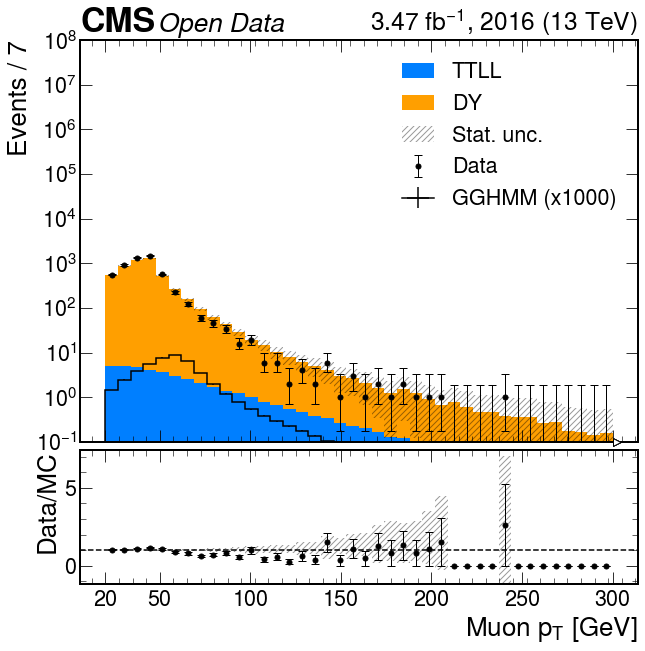

In [81]:
with open("histograms.pkl", "rb") as f:
    h2 = pickle.load(f)
    print(h2)
    print()
    print(h2.keys())
    print()

    #for keys in h2:
     #   print(keys)
      #  print(h2[keys])

    ### list of bkgs to plot
    dictBkgs = OrderedDict()
    dictBkgs["DY"] = { "color" : "#007fff", "label" : "EW" }
    dictBkgs["TTLL"] = { "color" : "#ff9f00", "label" : "EW" }


    bkgs = list(dictBkgs.keys())[::-1]
    print(bkgs)
    bkgs_colors = [ col["color"] for i, col in dictBkgs.items() ]
    print(bkgs_colors)
    bkgs_label = [ col["label"] for i, col in dictBkgs.items() ]

    plotHisto(h2,bkgs,xlog=True)

Plot saved as muon_eta.jpg


<Figure size 720x720 with 0 Axes>

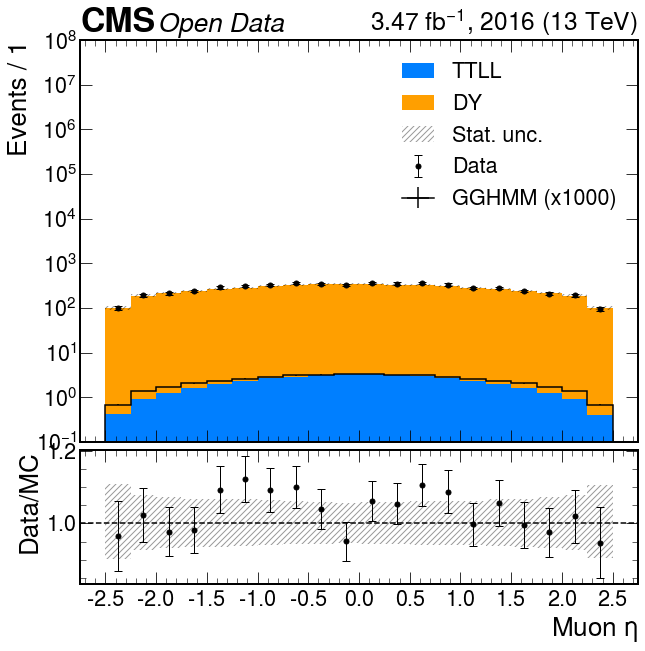

In [82]:
plotHisto(h2,bkgs,histName = "muon_eta", xlabel = "Muon $\eta$", rebinFactor = 1, xmin = -2.5j, xmax = 2.5j, xlog=True)

Plot saved as muon_phi.jpg


<Figure size 720x720 with 0 Axes>

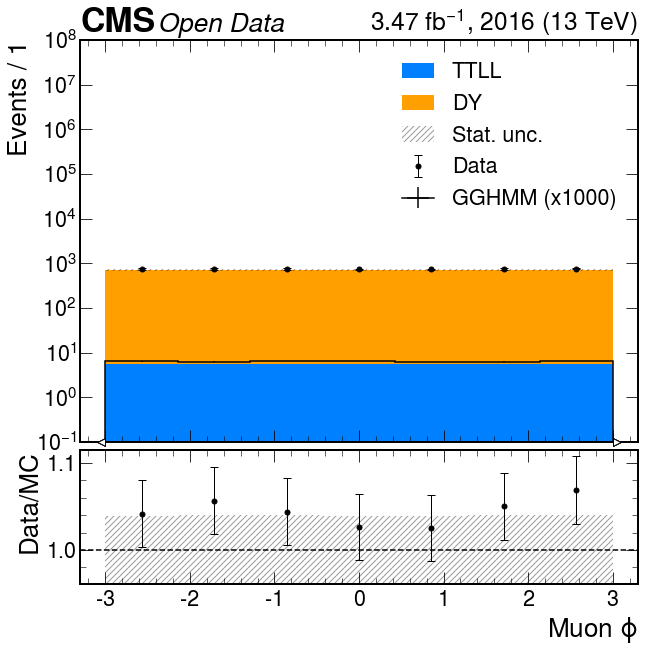

In [83]:
plotHisto(h2,bkgs,histName = "muon_phi", xlabel = "Muon $\phi$", rebinFactor = 1, xmin = -3j, xmax = 3j, xlog=True)

Plot saved as muon_mass_inv.jpg


<Figure size 720x720 with 0 Axes>

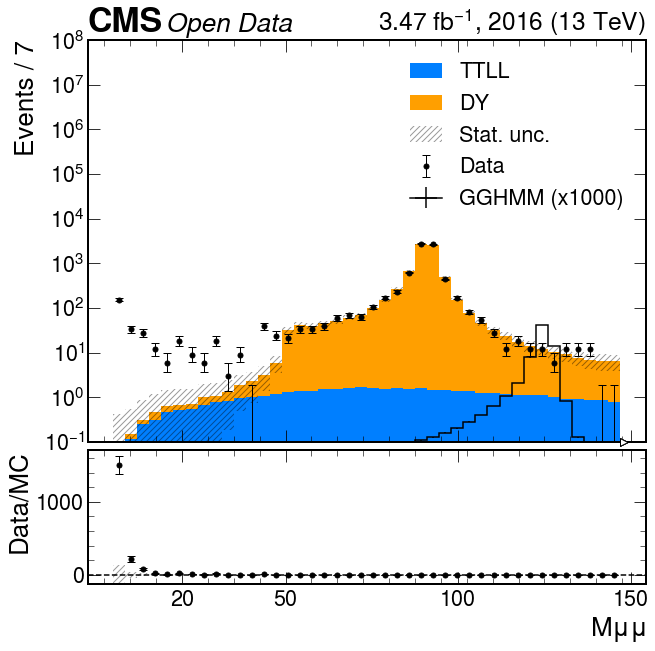

In [84]:
plotHisto(h2,bkgs,histName = "muon_mass_inv", xlabel = "$M{\mu \mu}$", xmin = 0, xmax = 300j, xlog=True)

Plot saved as muon_deltaR.jpg


<Figure size 720x720 with 0 Axes>

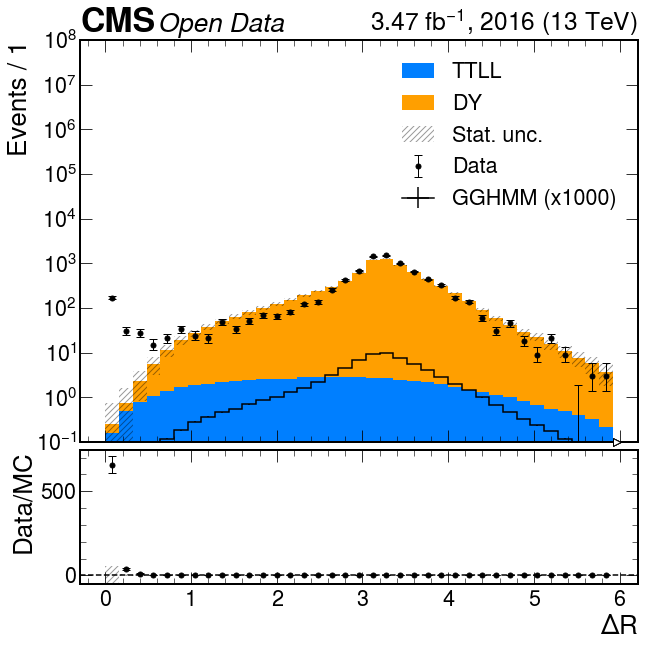

In [85]:
plotHisto(h2,bkgs,histName = "muon_deltaR", xlabel = "$\Delta$R", xmin = 0j, xmax = 6j, rebinFactor=1, xlog=True)